**Import bibliotek:**

In [1]:
import numpy as np
import tensorflow as tf

from sklearn.model_selection import train_test_split

from tensorflow.keras import layers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dropout
from tensorflow import keras

import os
import matplotlib.pyplot as plt

**Podział danych na zbiór treningowy, walidacyjny oraz testowy:**

In [2]:
(x_train_ld, y_train_ld), (x_test_ld, y_test_ld) = tf.keras.datasets.fashion_mnist.load_data()

images = np.concatenate([x_train_ld, x_test_ld], axis=0) # zbiór zawierający wszystkie zdjęcia
labels = np.concatenate([y_train_ld, y_test_ld], axis=0) # zbiór zawierający wszystkie etykiety

X_train_tt, X_test, y_train_tt, y_test = \
    train_test_split(images, labels, test_size=0.1, random_state=10, stratify=labels) #Podział na zbiór treningowy oraz testowy

X_train, X_val, y_train, y_val = \
    train_test_split(X_train_tt, y_train_tt, test_size=0.1, random_state=10, stratify=y_train_tt) #Wydzielenie zbiór treningowy oraz walidacyjnego z części treningowej.

**Tworzenie Datasetów TF:**

In [3]:
AUTOTUNE = tf.data.AUTOTUNE              # 
BATCH = 128                               # Zadeklarowanie wartości batch - porcja danych
        
def preprocess(x, y):
    x = tf.cast(x, tf.float32) / 255.0   # normalizacja wartości pikseli z zakresu 0-255 na 0-1.
    x = tf.expand_dims(x, -1)            # dodanie trzeciego wymiaru na tablicy
    return x, y

train_ds = (tf.data.Dataset.from_tensor_slices((X_train, y_train))           # tworzenie obiektu Dataset dla TF (obraz,etykieta)
            .shuffle(len(X_train), seed=42, reshuffle_each_iteration=True)   # tasuje dane (tasowanie w pełnym zakresie, losowość powtarzalna, dane będą tasowane przy kazdym przejściu przez epokę)
            .map(preprocess, num_parallel_calls=AUTOTUNE)                    # przetwarzanie danych (funkcja preprocess, zmiana wymiarów)
            .batch(BATCH).prefetch(AUTOTUNE))                                # grupuje dane na paczki po BATCH-elementów, przygotowuje kolejną porcję danych z wyprzedzeniem. 

val_ds = (tf.data.Dataset.from_tensor_slices((X_val, y_val))
          .map(preprocess, num_parallel_calls=AUTOTUNE)
          .batch(BATCH).prefetch(AUTOTUNE))

test_ds = (tf.data.Dataset.from_tensor_slices((X_test, y_test))
           .map(preprocess, num_parallel_calls=AUTOTUNE)
           .batch(BATCH).prefetch(AUTOTUNE))

**Tworzenie Sieci CNN oraz kompilacja:**

In [4]:
f_mnist_model = tf.keras.Sequential([
    layers.Input(shape=(28, 28, 1)),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.4),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(10, activation='softmax')])

f_mnist_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adamW',
    metrics=['accuracy'])

**Deklarowanie callbacków:**

In [5]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=4,
    min_lr=1e-7,
    verbose=1)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True,
    verbose=1)

ckpt = ModelCheckpoint(
    'best_model.keras', 
    monitor='val_loss', 
    save_best_only=True, 
    verbose=1)

**Trenowanie CNN:**

In [6]:
history = f_mnist_model.fit(
    train_ds,
    validation_data= val_ds,
    epochs=40,
    callbacks=[reduce_lr, early_stop, ckpt],
    verbose=1)

Epoch 1/40
443/443 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.5248 - loss: 1.2749
Epoch 1: val_loss improved from inf to 0.88096, saving model to best_model.keras
443/443 ━━━━━━━━━━━━━━━━━━━━ 37s 80ms/step - accuracy: 0.5250 - loss: 1.2741 - val_accuracy: 0.7686 - val_loss: 0.8810 - learning_rate: 0.0010
Epoch 2/40
443/443 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.7797 - loss: 0.6015
Epoch 2: val_loss improved from 0.88096 to 0.46686, saving model to best_model.keras
443/443 ━━━━━━━━━━━━━━━━━━━━ 55s 122ms/step - accuracy: 0.7798 - loss: 0.6015 - val_accuracy: 0.8321 - val_loss: 0.4669 - learning_rate: 0.0010
Epoch 3/40
443/443 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.8235 - loss: 0.4952
Epoch 3: val_loss improved from 0.46686 to 0.41360, saving model to best_model.keras
443/443 ━━━━━━━━━━━━━━━━━━━━ 54s 122ms/step - accuracy: 0.8235 - loss: 0.4951 - val_accuracy: 0.8457 - val_loss: 0.4136 - learning_rate: 0.0010
Epoch 4/40
443/443 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step -

Epoch 23/40
443/443 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9201 - loss: 0.2222
Epoch 23: val_loss did not improve from 0.21303
443/443 ━━━━━━━━━━━━━━━━━━━━ 55s 123ms/step - accuracy: 0.9201 - loss: 0.2222 - val_accuracy: 0.9065 - val_loss: 0.2463 - learning_rate: 0.0010
Epoch 24/40
443/443 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9188 - loss: 0.2179
Epoch 24: val_loss improved from 0.21303 to 0.21032, saving model to best_model.keras
443/443 ━━━━━━━━━━━━━━━━━━━━ 54s 122ms/step - accuracy: 0.9188 - loss: 0.2179 - val_accuracy: 0.9203 - val_loss: 0.2103 - learning_rate: 0.0010
Epoch 25/40
443/443 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.9221 - loss: 0.2109
Epoch 25: val_loss did not improve from 0.21032
443/443 ━━━━━━━━━━━━━━━━━━━━ 55s 123ms/step - accuracy: 0.9221 - loss: 0.2109 - val_accuracy: 0.9203 - val_loss: 0.2122 - learning_rate: 0.0010
Epoch 26/40
443/443 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.9227 - loss: 0.2107
Epoch 26: val_loss improved fr

**Weryfikacja metryk na zbiorze testowym:**  

In [7]:
test_loss, test_acc = f_mnist_model.evaluate(test_ds, verbose=1)
print(f"Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.9357 - loss: 0.1673
Test loss: 0.1661 | Test acc: 0.9391


**Podsumowanie modelu CNN:**

In [8]:
f_mnist_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 28, 28, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 28, 28, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 14, 14, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 385,056 (1.47 MB)

 Trainable params: 128,330 (501.29 KB)

 Non-trainable params: 64 (256.00 B)

 Optimizer params: 256,662 (1002.59 KB)

**Sprawdź czy istniee folder:"export", jeśli nie to to stwórz:**

In [9]:
os.makedirs("export", exist_ok=True)
f_mnist_model.save("export/fashion_cnn_savedmodel.keras")

**Export modelu do folderu:**

In [10]:
f_mnist_model.save("export/fashion_cnn_savedmodel.keras")

**Import modelu:**

In [11]:
model_imported = tf.keras.models.load_model("export/fashion_cnn_savedmodel.keras")

**Tworzenie funkcji/interfejsu która przedstawi nam wskazany obraz, etykietę oraz predykcję modelu:**

In [12]:
def show_prediction(model, X_test, y_test, idx):
    
    product_names = [
        "T-shirt/top","Trouser","Pullover","Dress","Coat",
        "Sandal","Shirt","Sneaker","Bag","Ankle boot"]
    
   
    x = np.expand_dims(np.expand_dims(X_test[idx].astype("float32") / 255.0, -1), 0)

    probs = model.predict(x, verbose=0)
    y_pred = np.argmax(probs, axis=1)[0]
    conf = probs[0, y_pred]

    true_name = product_names[int(y_test[idx])]
    pred_name = product_names[y_pred]

    plt.imshow(X_test[idx], cmap="gray")
    plt.title(f"Etykieta: {true_name}\nPredykcja: {pred_name} ({conf:.2f})")
    plt.axis("off")
    plt.show()

**Wpisz wartość dla "nr_foto" aby poniżej ruchamiając funkcję wyświetlić obrazek, etykietę oraz predykcję:**

In [13]:
nr_foto = 113

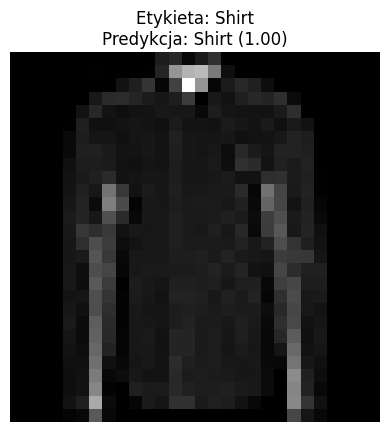

In [14]:
show_prediction(model_imported,X_test, y_test,nr_foto)